**colab과 google drive 연동을 위한 인증 및 네트웍 디렉토리 마운트**

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**연동 후 자신의 google drive에 있는 data 디렉토리 확인**

In [2]:
!cd "/content/drive/My Drive/data"; ls -l

total 329893
-rw------- 1 root root 337809843 Nov 11  2017 mercari_train.tsv


**기타 환경 정보 확인**

In [3]:
!cat /proc/meminfo;cat /proc/cpuinfo

MemTotal:       13333540 kB
MemFree:        10574104 kB
MemAvailable:   12464400 kB
Buffers:           76316 kB
Cached:          1967040 kB
SwapCached:            0 kB
Active:           746784 kB
Inactive:        1744892 kB
Active(anon):     426388 kB
Inactive(anon):      320 kB
Active(file):     320396 kB
Inactive(file):  1744572 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              3812 kB
Writeback:             0 kB
AnonPages:        448300 kB
Mapped:           247204 kB
Shmem:               904 kB
Slab:             170072 kB
SReclaimable:     132556 kB
SUnreclaim:        37516 kB
KernelStack:        4128 kB
PageTables:         5828 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666768 kB
Committed_AS:    2820224 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

### 데이터 전처리

In [5]:
### Data 전처리
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
### Text Data 전처리를 위한 library
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/drive/My Drive/data/mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


* train_id: 데이터 id
* name: 제품명
* item_condition_id: 판매자가 제공하는 제품 상태
* category_name: 카테고리 명
* brand_name: 브랜드 이름
* price: 제품 가격. 예측을 위한 타깃 속성
* shipping: 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
* item_description: 제품에 대한 설명

In [6]:
print(mercari_df.info())

### 총 건수 1,482,534 건 -> Null 을 가진 컬럼 존재 category name, brand name, item description 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


**타겟값의 분포도 확인**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


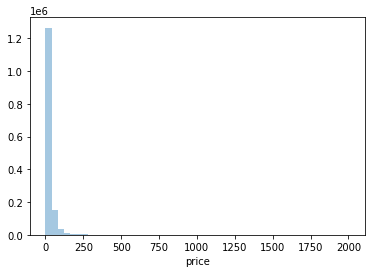

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df,kde=False)

**타겟값 로그 변환 후 분포도 확인**

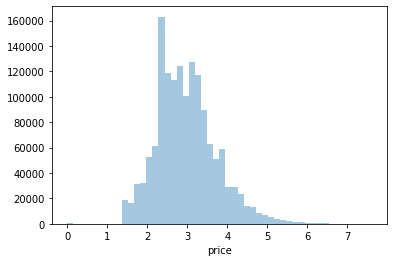

In [8]:
import numpy as np

### 기존 target value 에서 log value로 변경 
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df,kde=False)


In [9]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

**각 피처들의 유형 살펴보기**

In [10]:
### 배송비 무료 유무
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
### 제품에 대한 설명 
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())


Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


**category name이 대/중/소 와 같이 '/' 문자열 기반으로 되어 있음. 이를 개별 컬럼들로 재 생성**

In [11]:
### Boolean indexing
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [16]:
mercari_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...


In [19]:
############################### apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
# '/' 가 없는 경우 error 가 발생하여 try : , except: 이용
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

############################## 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
### 3개의 컬럼에 할당하기 위해 zip 을 이용하고, '*' tuple 로 변환하는 역할 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())


대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


In [20]:
'test1/test2/test3'.split('/')

['test1', 'test2', 'test3']

In [21]:
### 또다른 방법
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성. 
mercari_df['category_list'] = mercari_df['category_name'].apply(lambda x : split_cat(x))
mercari_df['category_list'].head()

0                                [Men, Tops, T-shirts]
1    [Electronics, Computers & Tablets, Components ...
2                      [Women, Tops & Blouses, Blouse]
3               [Home, Home Décor, Home Décor Accents]
4                          [Women, Jewelry, Necklaces]
Name: category_list, dtype: object

In [0]:
mercari_df['cat_dae'] = mercari_df['category_list'].apply(lambda x:x[0])
mercari_df['cat_jung'] = mercari_df['category_list'].apply(lambda x:x[1])
mercari_df['cat_so'] = mercari_df['category_list'].apply(lambda x:x[2])

mercari_df.drop('category_list', axis=1, inplace=True) 

In [23]:
mercari_df[['cat_dae','cat_jung','cat_so']].head()

,cat_dae,cat_jung,cat_so
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


**Null값 일괄 처리**

In [24]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [25]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1482535 non-null  object 
 4   brand_name         1482535 non-null  object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482535 non-null  object 
 8   cat_dae            1482535 non-null  object 
 9   cat_jung           1482535 non-null  object 
 10  cat_so             1482535 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


### 피처 인코딩과 피처 벡터화

**brand name과 name의 종류 확인**

In [26]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

### 4,810 barand name 건수는 one-hot encoding 결정

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [27]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

### name 의 경우 brand name 보다 훨씬 많은 1,225,273건 이므로 one-hot encoding 불가하여 텍스트 피쳐 벡터화 필요
### 적은 단어 위주의 텍스트 형태로 구성되어 있기 때문에 Count 기반으로 피처 벡터화 적용 

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


**item_description의 문자열 개수 확인**

- set_option (pat, value)-지정된 옵션의 값을 설정합니다
- 사용 가능한 옵션 :
chop_threshold, colheader_justify, column_space, date_dayfirst, date_yearfirst, 인코딩, expand_frame_repr, float_format, 높이, line_width, max_columns, max_colwidth, max_info_columns, max_info_rows, max_rows, max_seq_items, mpl_style, multi_sparse, notebook_repr_html, pprint_nest_depth, 정밀도, 너비 mode. 
- https://it-man.tistory.com/536

In [28]:
##### 출력 형태 설정 pd.set_option 
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [29]:
import gc
gc.collect()

0

**name은 Count로, item_description은 TF-IDF로 피처 벡터화**

In [30]:
# name 속성에 대한 feature vectorization 변환
cnt_vec = CountVectorizer(max_features=30000)
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 feature vectorization 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)


name vectorization shape: (1482535, 30000)
item_description vectorization shape: (1482535, 50000)


**사이킷런의 LabelBinarizer를 이용하여 원-핫 인코딩 변환 후 희소행렬 최적화 형태로 저장**

In [0]:
##### Text 형 컬럼 2개는 희소행렬로 변환이 되었기 때문에 결합을 위해 다른 카테고리 컬럼도 희소행렬로 변환이 필요
##### 희소행렬 변환 Option을 가지고 있는 'LabelBinarizer' 을 이용하여 One-hot encoding 과 희소행렬 변환을 동시에 진행
##### 각 컬럼의 결합은 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용할 예정

from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [32]:
### 생성된 컬럼의 갯수 확인 가능 
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


**피처 벡터화된 희소 행렬과 원-핫 인코딩된 희소 행렬을 모두 scipy 패키지의 hstack()함수를 이용하여 결합**

In [33]:
from  scipy.sparse import hstack
import gc

### 각 희소행렬 컬럼 
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()


<class 'scipy.sparse.csr.csr_matrix'> (1482535, 85812)


0

### 릿지 회귀 모델 구축 및 평가

**rmsle 정의**

In [0]:
### 캐글에서 제시한 RMSLE 평가 지표 적용
### 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류가 더 커지는 것을 억제 하기 위해 이 방식을 사용 

def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요. 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

**여러 모델에 대한 학습/예측을 수행하기 위해 별도의 함수인 model_train_predict()생성.** 

** model_train_predict 함수의 인자는 Model 알고리즘, 사용 컬럼 **

해당 함수는 여러 희소 행렬을 hstack()으로 결합한 뒤 학습과 테스트 데이터 세트로 분할 후 모델 학습 및 예측을 수행 

In [0]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    ### 예측 후 제거!!!! 
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

**릿지 선형 회귀로 학습/예측/평가. Item Description 피처의 영향도를 알아보기 위한 테스트 함께 수행**

In [36]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

### Item Description 제외 한 컬럼 
sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

### 전체 컬럼 
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))


Item Description을 제외했을 때 rmsle 값: 0.5027973690574066
Item Description을 포함한 rmsle 값: 0.47114311507018


### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [37]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)


### n_estimators 커지면 커질수록 수행시간이 너무 길어지는 현상 
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.45668225613337415


In [38]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.45062742010765844
